# Darts regression model

In [1]:
import pandas as pd
from darts.models import RegressionModel
from sklearn.linear_model import RidgeCV
from darts.dataprocessing.transformers import Scaler

from src.utils import prepare_col, historical_forecasts, plot_forecasts

/scale_wlg_persistent/filesets/project/nesi99999/riom/LSTM-ML-for-teeth/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
dset = pd.read_csv("../results/dataset_minutes.csv")
dset

,material,sample,Time [min],Line Distance [m],Wear Loss [mm]
0,G1,S1,0,0.118,-0.001950
1,G1,S1,1,0.358,-0.000967
2,G1,S1,2,0.598,-0.001717
3,G1,S1,3,0.838,-0.000992
4,G1,S1,4,1.078,-0.001683
...,...,...,...,...,...
236802,G9,S5,4162,998.998,0.162267
236803,G9,S5,4163,999.238,0.164275
236804,G9,S5,4164,999.478,0.163733
236805,G9,S5,4165,999.718,0.163325


In [3]:
train_materials = ["G5", "G6", "G8", "G9"]
test_materials = ["G7"]

In [4]:
dset_train = dset[dset.material.isin(train_materials)]
groups_train = dset_train.groupby(["material", "sample"])
series_train = [prepare_col(group, "Wear Loss [mm]") for _, group in groups_train]
series_train_idx = [prepare_col(group, "Time [min]") for _, group in groups_train]

scaler = Scaler().fit([series_train[0], series_train_idx[0]])
series_train_scaled, series_train_idx_scaled = zip(
    *[scaler.transform(series) for series in zip(series_train, series_train_idx)]
)

## Model training

In [5]:
model = RegressionModel(lags=200, lags_future_covariates=[1], model=RidgeCV())

In [6]:
model.fit(series_train_scaled, future_covariates=series_train_idx_scaled)

## Predictions

In [7]:
n_warmup = [1000, 2000]

In [8]:
%%time
dset_pred = dset[dset.material.isin(train_materials + test_materials)]
forecasts = {
    key: historical_forecasts(model, scaler, group, n_warmup=n_warmup, n_lags=1)
    for key, group in dset_pred.groupby(["material", "sample"])
}

CPU times: user 52.1 s, sys: 306 ms, total: 52.4 s
Wall time: 52.1 s


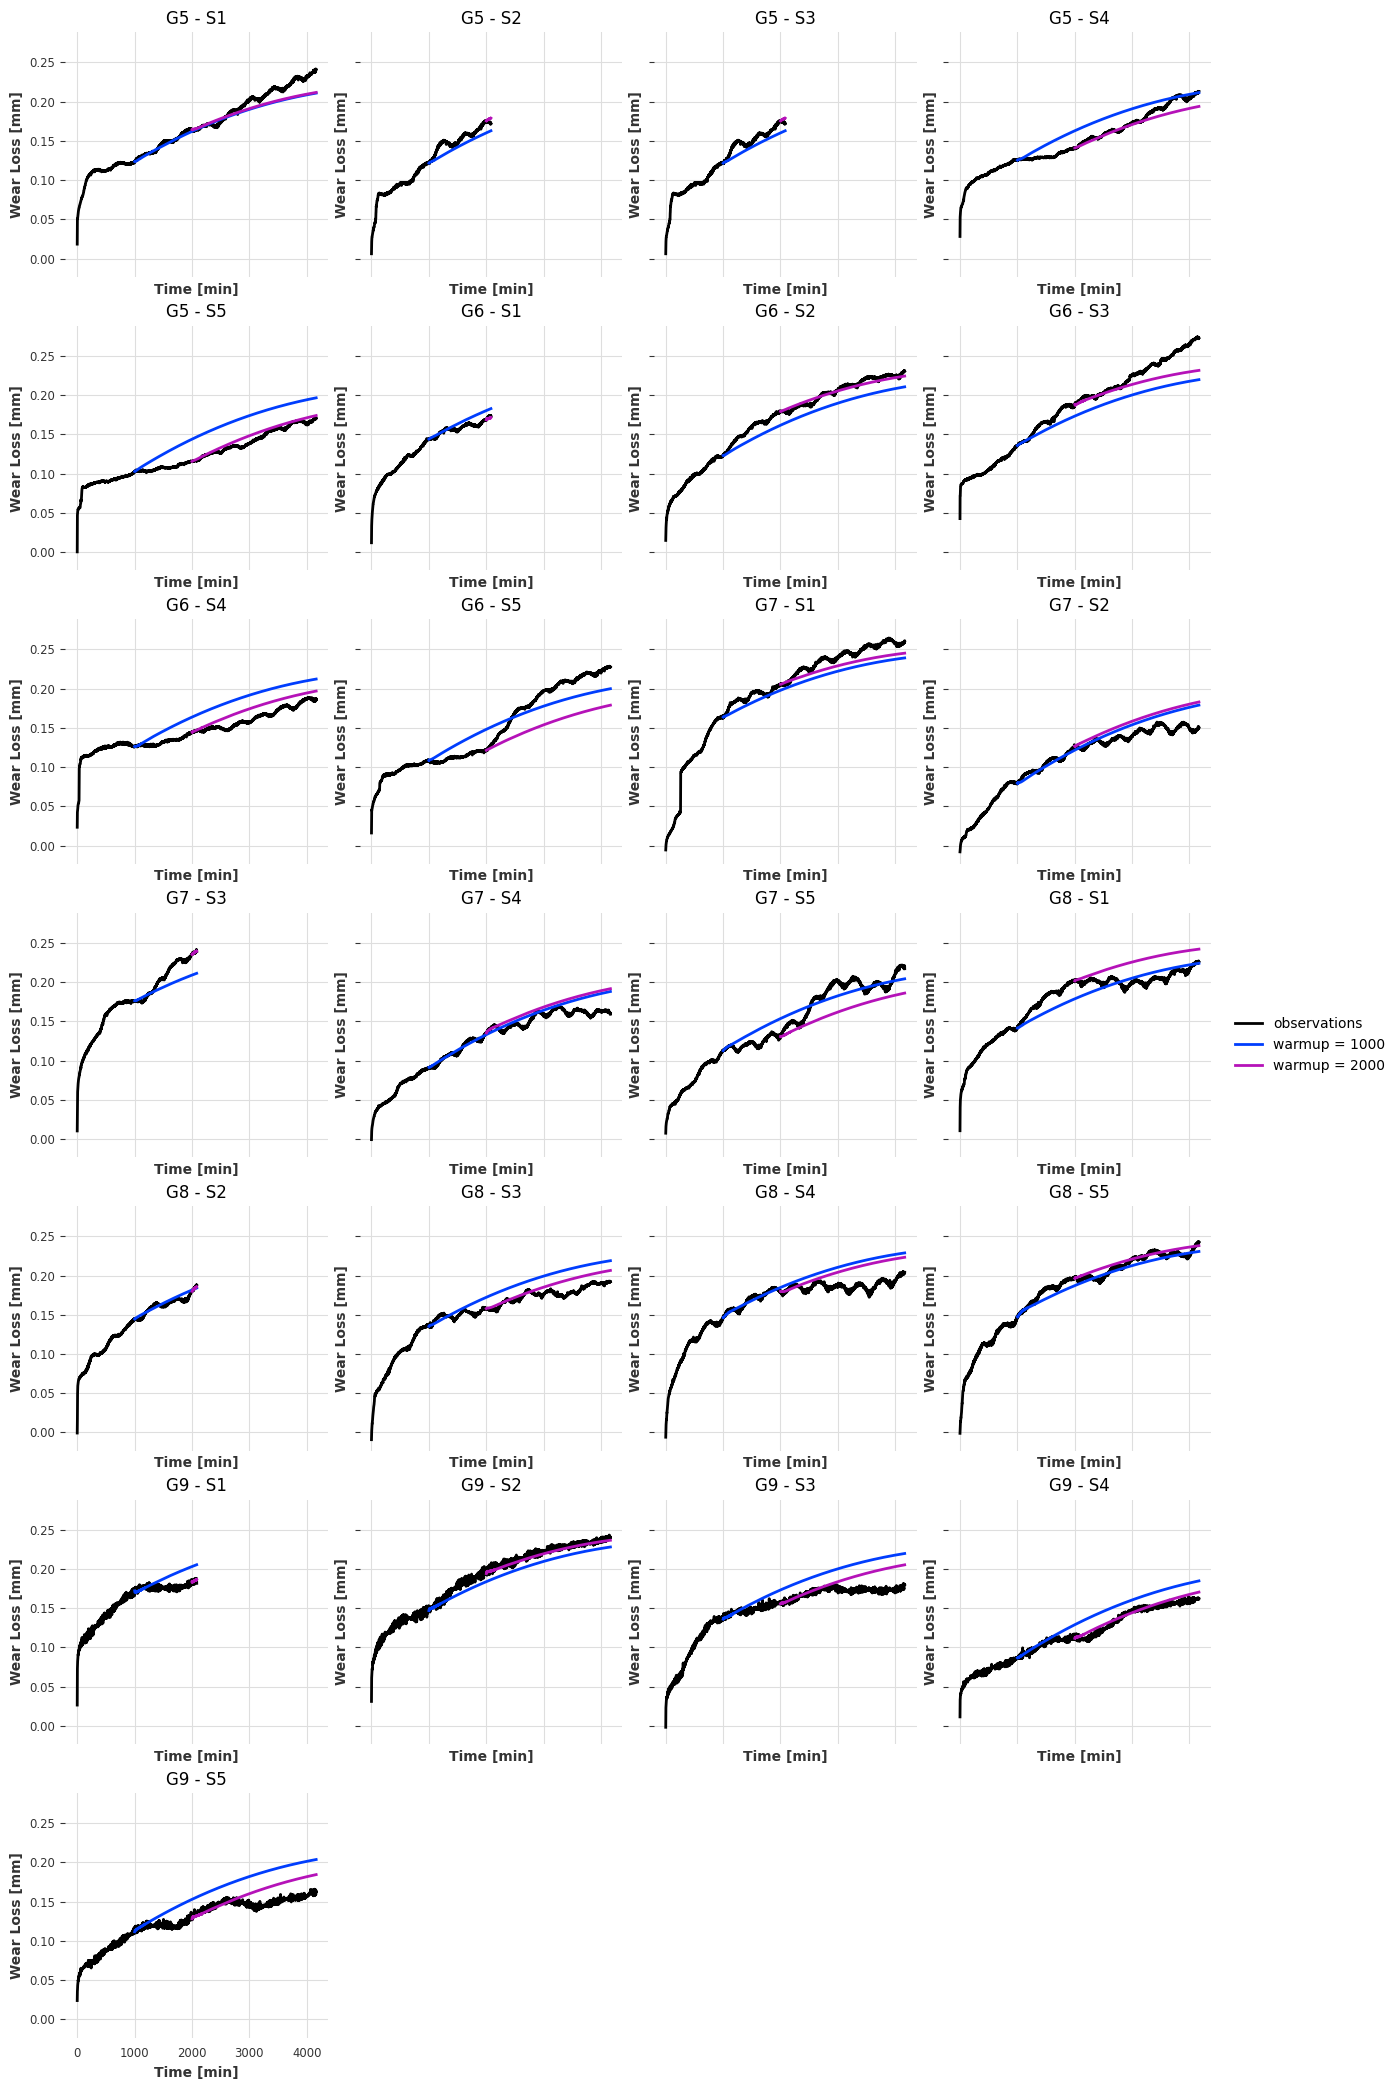

In [9]:
_ = plot_forecasts(forecasts, n_warmup, n_col=4)